### 1. 读图

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


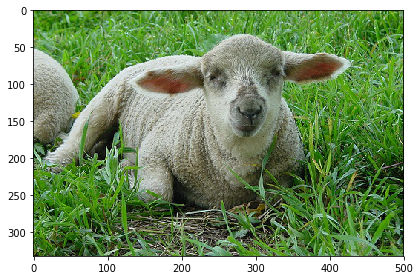

In [14]:
%matplotlib inline
import numpy as np
from skimage import io
#filepath="D:\\work\\stuff\\modules\\misc\\sprd_camera\\alg\\july\\tf_base\\featureTests\\LesssonTfrecord\\miniVOC\\JPEGImages\\2007_000175.jpg"
filepath="./miniVOC/JPEGImages/2007_000175.jpg"
img=io.imread(filepath)
io.imshow(img)

In [15]:
# 转换成string
string_img=img.tostring()
#print(string_img)

In [16]:
reconstructed_img_1d=np.fromstring(string_img,dtype=np.uint8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


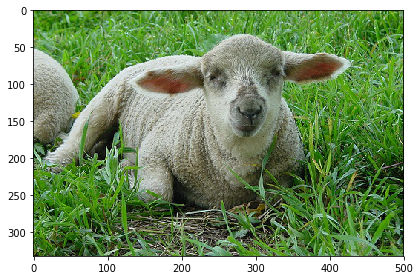

In [17]:
reconstructed_img=reconstructed_img_1d.reshape(img.shape)
io.imshow(reconstructed_img)

In [18]:
#检查原图和重构图
np.allclose(img,reconstructed_img)

True

### 实验二 创建tfrecord并在不建立graph情况下读取它.

In [19]:
filename_pairs = [
('./miniVOC/JPEGImages/2007_000175.jpg',
'./miniVOC/SegmentationClass/2007_000175.png'),
('./miniVOC/JPEGImages/2007_000032.jpg',
'./miniVOC/SegmentationClass/2007_000032.png'),
('./miniVOC/JPEGImages/2007_000033.jpg',    
'./miniVOC/SegmentationClass/2007_000033.png'),
('./miniVOC/JPEGImages/2007_000039.jpg',    
'./miniVOC/SegmentationClass/2007_000039.png'),
('./miniVOC/JPEGImages/2007_000042.jpg',    
'./miniVOC/SegmentationClass/2007_000042.png'),
('./miniVOC/JPEGImages/2007_000061.jpg',    
'./miniVOC/SegmentationClass/2007_000061.png'),
('./miniVOC/JPEGImages/2007_000063.jpg',    
'./miniVOC/SegmentationClass/2007_000063.png'),
('./miniVOC/JPEGImages/2007_000068.jpg',    
'./miniVOC/SegmentationClass/2007_000068.png'),
('./miniVOC/JPEGImages/2007_000121.jpg',    
'./miniVOC/SegmentationClass/2007_000121.png'),
('./miniVOC/JPEGImages/2007_000123.jpg',    
'./miniVOC/SegmentationClass/2007_000123.png'),
('./miniVOC/JPEGImages/2007_000129.jpg',    
'./miniVOC/SegmentationClass/2007_000129.png'),
('./miniVOC/JPEGImages/2007_000170.jpg',    
'./miniVOC/SegmentationClass/2007_000170.png'),
('./miniVOC/JPEGImages/2007_000175.jpg',    
'./miniVOC/SegmentationClass/2007_000175.png'),
('./miniVOC/JPEGImages/2007_000187.jpg',    
'./miniVOC/SegmentationClass/2007_000187.png'),
('./miniVOC/JPEGImages/2007_000241.jpg',    
'./miniVOC/SegmentationClass/2007_000241.png'),
('./miniVOC/JPEGImages/2007_000243.jpg',    
'./miniVOC/SegmentationClass/2007_000243.png'),
('./miniVOC/JPEGImages/2007_000250.jpg',    
'./miniVOC/SegmentationClass/2007_000250.png'),
('./miniVOC/JPEGImages/2007_000256.jpg',    
'./miniVOC/SegmentationClass/2007_000256.png'),
('./miniVOC/JPEGImages/2007_000323.jpg',    
'./miniVOC/SegmentationClass/2007_000323.png'),
]

In [20]:
import tensorflow as tf
from PIL import Image
# helper函数,构造tf.train.Feature.
def _bytes_features(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_features(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecord_filename='pascal_minivoc_segmentation.tfrecords'
writer=tf.python_io.TFRecordWriter(tfrecord_filename)

original_imgs=[] # 保存之前的imgs.

for img,img_mask in filename_pairs:
    img=np.array(Image.open(img))
    img_mask=np.array(Image.open(img_mask))
    height=img.shape[0]
    width=img.shape[1]
    
    # 暂存
    original_imgs.append((img,img_mask))
    
    # 取出raw数据
    img_raw = img.tostring()
    img_mask_raw=img_mask.tostring()
    example=tf.train.Example(features=tf.train.Features(feature={
        'height':_int64_features(height),
        'width':_int64_features(width),
        'img_raw':_bytes_features(img_raw),
        'img_mask_raw':_bytes_features(img_mask_raw)}))
    writer.write(example.SerializeToString())
writer.close()

In [25]:
reconstruction_img=[]

record_iterator=tf.python_io.tf_record_iterator(path=tfrecord_filename)

for string_record in record_iterator:
    example=tf.train.Example()
    example.ParseFromString(string_record)
    height=int(example.features.feature['height'].int64_list.value[0])
    width=int(example.features.feature['width'].int64_list.value[0])
    img_string=(example.features.feature['img_raw'].bytes_list.value[0])
    img_mask_string=(example.features.feature['img_mask_raw'].bytes_list.value[0]) # 这里没有int转换
    img_re_1d=np.fromstring(img_string,dtype=np.uint8)
    img_mask_re_1d=np.fromstring(img_mask_string,dtype=np.uint8)
    reimg=img_re_1d.reshape((height,width,-1))
    remaskimg=img_mask_re_1d.reshape((height,width))
    reconstruction_img.append((reimg,remaskimg))

for original_img_pair,reconstruction_img_pair in zip(original_imgs,reconstruction_img):
    img_compare,img_mask_compare=zip(original_img_pair,reconstruction_img_pair)
    print(np.allclose(*img_compare))
    print(np.allclose(*img_mask_compare))

    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### 实验三 在Graph下对tfrecord的图片进行批量读取

In [30]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 384
IMAGE_WIDTH = 384

tfrecords_filename = 'pascal_minivoc_segmentation.tfrecords'

def read_and_decode(filename_queue):
    """
    param:
    filename_queue:
        传入的tf.train.string_input_producer类型.
    return:
        img,img_mask
    """
    reader=tf.TFRecordReader()
    _,serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(serialized_example,features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'img_raw': tf.FixedLenFeature([], tf.string),
        'img_mask_raw': tf.FixedLenFeature([], tf.string)}) # 注意是string类型.

    imgraw = tf.decode_raw(features['img_raw'],tf.uint8)
    imgmaskraw = tf.decode_raw(features['img_mask_raw'],tf.uint8)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    imgshape= tf.stack([height, width, 3]) # pack改为stack
    imgmaskshape = tf.stack([height, width, 1])
    
    imgraw=tf.reshape(imgraw,imgshape)
    imgmaskraw=tf.reshape(imgmaskraw,imgmaskshape)
    image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    image_mask_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=tf.int32)
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=imgraw,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_image_mask = tf.image.resize_image_with_crop_or_pad(image=imgmaskraw,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    
    images, masks = tf.train.shuffle_batch( [resized_image, resized_image_mask],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, masks




In [31]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)


(384, 384, 3)
current batch


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


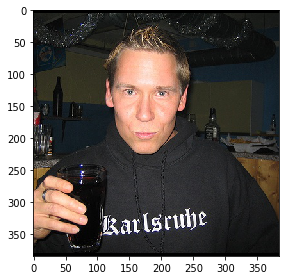

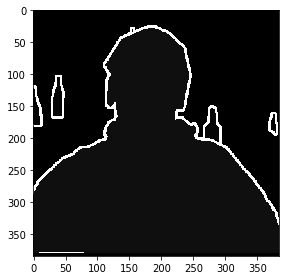

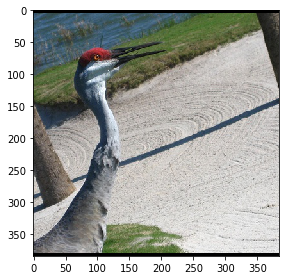

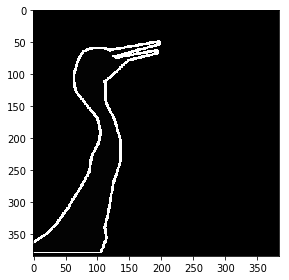

(384, 384, 3)
current batch


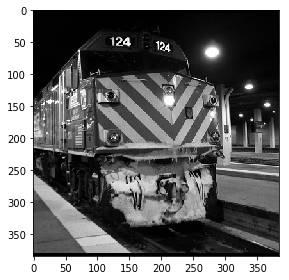

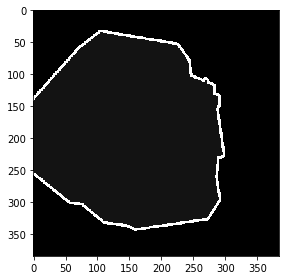

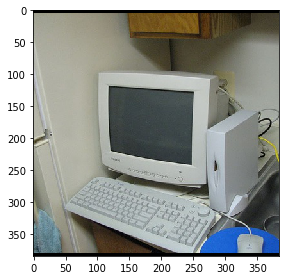

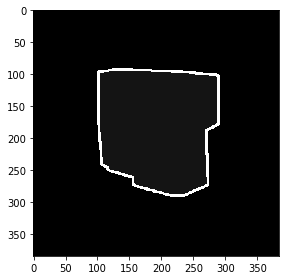

(384, 384, 3)
current batch


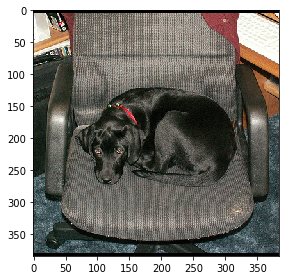

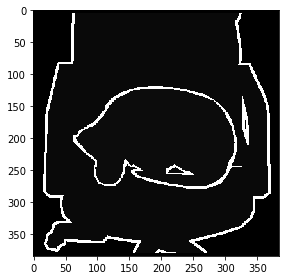

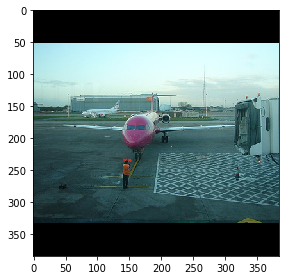

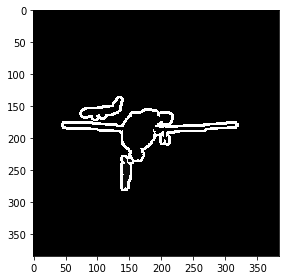

In [33]:
image, annotation = read_and_decode(filename_queue)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(3):
    
        img, anno = sess.run([image, annotation])
        print(img[0, :, :, :].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(img[0, :, :, :])
        io.show()

        io.imshow(anno[0, :, :, 0])
        io.show()
        
        io.imshow(img[1, :, :, :])
        io.show()

        io.imshow(anno[1, :, :, 0])
        io.show()
        
    
    coord.request_stop()
    coord.join(threads)
